In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import shutil 
from tqdm import tqdm

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip


In [2]:
def MyRemoveBackground(path):
    
    in_img = cv2.imread(path)

    # Get the height and width from OpenCV image
    height, width = in_img.shape[:2]

    # Create a mask holder
    mask = np.zeros([height, width], np.uint8)

    # Grab Cut the object
    bgdModel = np.zeros((1, 65),np.float64)
    fgdModel = np.zeros((1, 65),np.float64)

    # Hard Coding the Rect The object must lie within this rect.
    rect = (15, 15, width-30, height-30)
    cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    out_img = in_img * mask[:, :, np.newaxis]

    # Get the background
    background = in_img - out_img

    # Change all pixels in the background that are not black to white
    background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

    #Add the background and the image
    out_img = background + out_img

    return out_img

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    

In [3]:
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
    zip_obj.extractall('/kaggle/working/')

In [4]:
data_path = '/kaggle/working/plates/'
print(os.listdir(data_path))

['train', 'test', '.DS_Store']


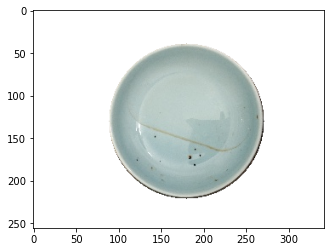

In [5]:
def circle(path):
    
    img = cv2.imread(path)

    try:

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # detect circles
        gray = cv2.medianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 5)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=50, minRadius=90, maxRadius=0)
        circles = np.uint16(np.around(circles))

        # draw mask
        mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)  # mask is only 
        for i in circles[0, :]:
            cv2.circle(mask, (i[0], i[1]), i[2], (255, 255, 255), -1)

        # get first masked value (foreground)
        fg = cv2.bitwise_or(img, img, mask=mask)

        # get second masked value (background) mask must be inverted
        mask = cv2.bitwise_not(mask)
        background = np.full(img.shape, 255, dtype=np.uint8)
        bk = cv2.bitwise_or(background, background, mask=mask)

        # combine foreground+background
        final = cv2.bitwise_or(fg, bk)
        return final
    except:
        return img
plt.imshow(circle('/kaggle/working/plates/test/0567.jpg'))

In [6]:
for class_name in ['cleaned', 'dirty']:
    path = os.path.join(data_path, 'train', class_name)
    for image in tqdm(os.listdir(path)):
        if image.split('.')[-1] == 'jpg':
            image_path = os.path.join(path, image)
            #new_image = circle(image_path)
            new_image = MyRemoveBackground(image_path)
            new_image = Image.fromarray(new_image)
            new_image.save(os.path.join(path, image))
            
path = os.path.join(data_path, 'test')
for image in tqdm(os.listdir(os.path.join(data_path, 'test'))):
    if image.split('.')[-1] == 'jpg':
        image_path = os.path.join(os.path.join(data_path, 'test'), image)
        #new_image = circle(image_path)
        new_image = MyRemoveBackground(image_path)
        new_image = Image.fromarray(new_image)
        new_image.save(os.path.join(path, image))



100%|██████████| 745/745 [16:10<00:00,  1.30s/it]


In [7]:
os.makedirs(os.path.join('train', 'cleaned'), exist_ok=True) #/kaggle/working/train/cleaned
os.makedirs(os.path.join('train', 'dirty'), exist_ok=True) #/kaggle/working/train/dirty
os.makedirs(os.path.join('val', 'cleaned'), exist_ok=True) #/kaggle/working/val/cleaned
os.makedirs(os.path.join('val', 'dirty'), exist_ok=True) #/kaggle/working/val/dirty
os.makedirs(os.path.join('test', 'unknown'), exist_ok=True) #/kaggle/working/test


for class_name in ['cleaned', 'dirty']:
    old_dir = os.path.join(data_path, 'train', class_name) #/kaggle/working/plates/train/...
    for i, file in enumerate(tqdm(os.listdir(old_dir))):
        if i % 6 == 0:
            new_dir = os.path.join('val', class_name) #/kaggle/working/val/...
        else:
            new_dir = os.path.join('train', class_name)
        shutil.copy(os.path.join(old_dir, file), os.path.join(new_dir, file))
        

for test_im in tqdm(os.listdir(os.path.join(data_path, 'test'))):
    shutil.copy(os.path.join(data_path, 'test', test_im), os.path.join('test', 'unknown'))

100%|██████████| 745/745 [00:00<00:00, 8678.41it/s]


In [8]:
!ls train

cleaned  dirty


In [9]:
train_transforms = transforms.Compose([
    transforms.RandomChoice([transforms.CenterCrop(180),
                         transforms.CenterCrop(160),
                         transforms.CenterCrop(140),
                         transforms.CenterCrop(120)]),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255), 
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

val_transforms = transforms.Compose([
    transforms.RandomChoice([transforms.CenterCrop(180),
                             transforms.CenterCrop(160),
                             transforms.CenterCrop(140),
                             transforms.CenterCrop(120)]),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),     
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

train_dataset = torchvision.datasets.ImageFolder('train', train_transforms)
val_dataset = torchvision.datasets.ImageFolder('val', val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [10]:
len(train_dataloader), len(train_dataset)

(2, 32)

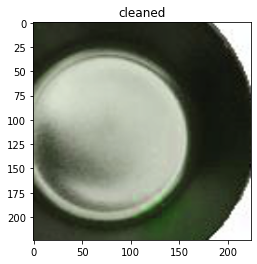

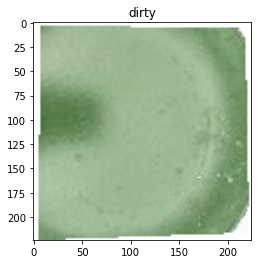

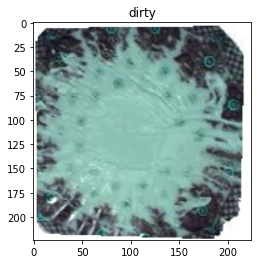

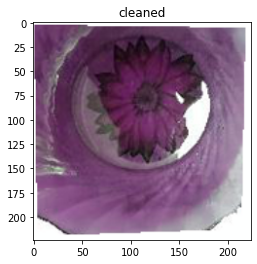

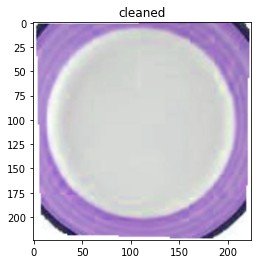

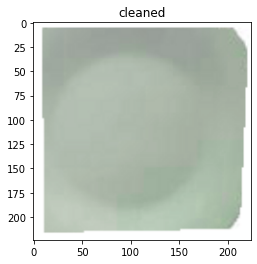

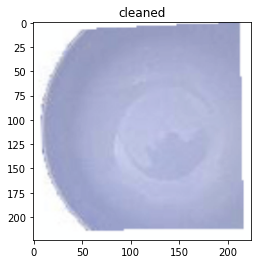

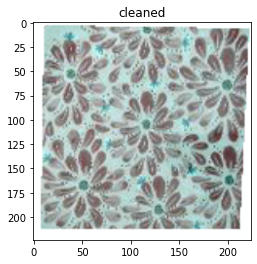

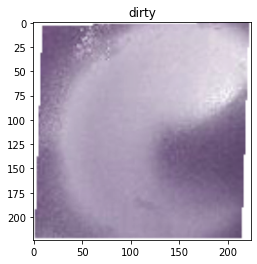

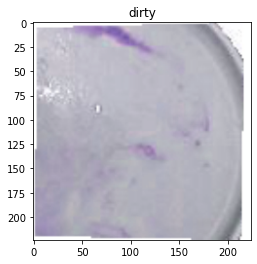

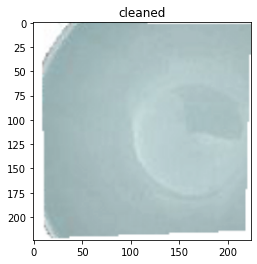

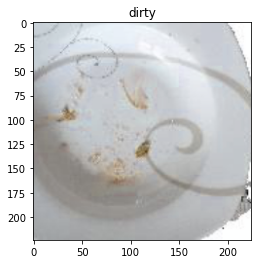

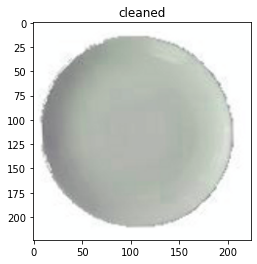

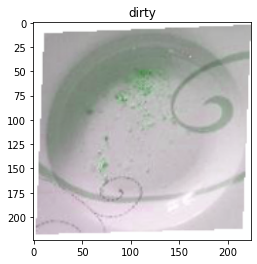

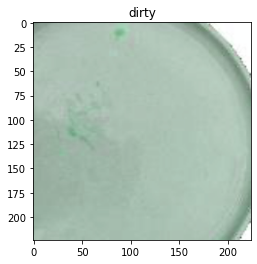

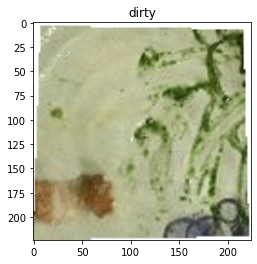

In [11]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)

X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=['cleaned', 'dirty'][y_item])

In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

In [15]:
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [16]:
train_model(model, loss, optimizer, scheduler, num_epochs=20);

Epoch 1/20:train Loss: 0.7155 Acc: 0.5625
val Loss: 0.6754 Acc: 0.5000
Epoch 2/20:train Loss: 0.6164 Acc: 0.6875
val Loss: 0.6598 Acc: 0.5000
Epoch 3/20:train Loss: 0.5908 Acc: 0.7812
val Loss: 0.6082 Acc: 0.6250
Epoch 4/20:train Loss: 0.5836 Acc: 0.7812
val Loss: 0.6099 Acc: 0.6250
Epoch 5/20:train Loss: 0.4744 Acc: 0.8438
val Loss: 0.7723 Acc: 0.5000
Epoch 6/20:train Loss: 0.4352 Acc: 0.8438
val Loss: 0.6026 Acc: 0.5000
Epoch 7/20:train Loss: 0.4359 Acc: 0.9062
val Loss: 0.5637 Acc: 0.6250
Epoch 8/20:train Loss: 0.4048 Acc: 0.8438
val Loss: 0.6370 Acc: 0.6250
Epoch 9/20:train Loss: 0.4214 Acc: 0.7500
val Loss: 0.4698 Acc: 0.7500
Epoch 10/20:train Loss: 0.3639 Acc: 0.8750
val Loss: 0.6654 Acc: 0.5000
Epoch 11/20:train Loss: 0.3530 Acc: 0.8750
val Loss: 0.6752 Acc: 0.6250
Epoch 12/20:train Loss: 0.3536 Acc: 0.8750
val Loss: 0.8056 Acc: 0.5000
Epoch 13/20:train Loss: 0.3294 Acc: 0.9062
val Loss: 0.8096 Acc: 0.5000
Epoch 14/20:train Loss: 0.3156 Acc: 0.9062
val Loss: 0.4835 Acc: 0.6250
E

In [ ]:
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')